In [85]:
import pandas as pd
import seaborn as sns

from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster,cut_tree,set_link_color_palette
import sklearn.decomposition
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from matplotlib import cm,colors
import itertools

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import sys

In [7]:
expression_df = pd.read_table("./data/TCGA_BRCA_EXP.v1.gct",index_col=0,skiprows=2)
expression_df = expression_df[[c for c in expression_df.columns if c !="Description"]]
expression_df = expression_df.rename(columns={c:c.replace("_","-") for c in expression_df.columns})
expression_df.head()

,TCGA-3C-AAAU,TCGA-3C-AALI,TCGA-3C-AALJ,TCGA-3C-AALK,TCGA-4H-AAAK,TCGA-5L-AAT0,TCGA-5L-AAT1,TCGA-5T-A9QA,TCGA-A1-A0SB,TCGA-A1-A0SD,...,TCGA-UL-AAZ6,TCGA-UU-A93S,TCGA-V7-A7HQ,TCGA-W8-A86G,TCGA-WT-AB41,TCGA-WT-AB44,TCGA-XX-A899,TCGA-XX-A89A,TCGA-Z7-A8R5,TCGA-Z7-A8R6
Name,,,,,,,,,,,,,,,,,,,,,
A1BG,197.090,237.3840,423.2370,191.0180,268.8810,203.7720,211.296,314.184,49.1992,142.2980,...,44.1541,321.975,1032.0600,533.0380,119.8110,471.2850,223.2200,255.1350,439.5430,248.3270
A1CF,0.000,0.0000,0.9066,0.0000,0.4255,0.0000,0.000,0.523,0.0000,0.0000,...,0.3992,0.000,0.0000,0.4746,0.0000,0.0000,0.0000,2.3618,0.0000,0.0000
A2BP1,0.000,0.0000,0.0000,0.0000,3.8298,0.5866,0.000,0.523,4.5050,0.3308,...,0.0000,0.000,0.6158,5.2207,4.7319,0.0000,0.3937,1.4171,0.5973,0.0000
A2LD1,102.963,70.8646,161.2600,62.5072,154.3700,111.5350,101.972,233.619,37.8962,66.8630,...,188.8610,225.094,125.1810,59.7152,312.0580,61.7308,131.2280,79.9291,81.3010,25.1866
A2M,5798.370,7571.9800,8840.4000,10960.2000,9585.4400,12331.3000,15406.600,3182.480,31626.9000,23793.5000,...,4644.0500,3530.380,8051.5200,18325.0000,9580.9700,5409.3100,20348.8000,17094.8000,36838.5000,7339.1700


In [13]:
clinical_info_df = pd.read_csv("./data/TCGA_BRCA_clinical_FH.csv",index_col=0)
clinical_info_df.head()

,Breslow_thickness,acronym,age_at_diagnosis,age_began_smoking_in_years,cause_of_death,cervical_carcinoma_pelvic_extension_text,cervix_suv_results,chemo_concurrent_type,clinical_stage,corpus_involvement,...,tobacco_smoking_year_stopped,tool,tumor_size,tumor_stage,tumor_status,tumor_tissue_site,vital_status,weight_kg_at_diagnosis,year_of_tobacco_smoking_onset,years_to_birth
TCGA-3C-AAAU,NaN,BRCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,clinical_pick_tier_1,NaN,NaN,NaN,breast,Alive,NaN,NaN,55.0
TCGA-3C-AALI,NaN,BRCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,clinical_pick_tier_1,NaN,NaN,NaN,breast,Alive,NaN,NaN,50.0
TCGA-3C-AALJ,NaN,BRCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,clinical_pick_tier_1,NaN,NaN,NaN,breast,Alive,NaN,NaN,62.0
TCGA-3C-AALK,NaN,BRCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,clinical_pick_tier_1,NaN,NaN,NaN,breast,Alive,NaN,NaN,52.0
TCGA-4H-AAAK,NaN,BRCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,clinical_pick_tier_1,NaN,NaN,NaN,breast,Alive,NaN,NaN,50.0


## 1. Data Cleaning

In [64]:
df = clinical_info_df[["days_to_last_followup",'days_to_death', 'vital_status']] 
df.loc[df["vital_status"]=="Dead"].head()

,days_to_last_followup,days_to_death,vital_status
TCGA-A1-A0SK,[Not Available],967,Dead
TCGA-A2-A04P,[Not Available],548,Dead
TCGA-A2-A04V,[Not Available],1920,Dead
TCGA-A2-A0CM,[Not Available],754,Dead
TCGA-A2-A0CO,3409,3492,Dead


In [93]:
df["days_to_last_followup"] = pd.to_numeric(df["days_to_last_followup"],errors="coerce")
df["days_to_death"] = pd.to_numeric(df["days_to_death"],errors="coerce")

vital_status_df_dict = {"sample":[],"event_time":[],"vital_status":[]}
for index,row in df.iterrows():
    timepoint = 0
    if row["vital_status"] =="Alive":
        if row.isnull()["days_to_last_followup"]==False:
            vital_status_df_dict["sample"].append(index)
            vital_status_df_dict["event_time"].append(row["days_to_last_followup"])
            vital_status_df_dict["vital_status"].append(row["vital_status"])
        elif row.isnull()["days_to_death"]==False:
            vital_status_df_dict["sample"].append(index)
            vital_status_df_dict["event_time"].append(row["days_to_death"])
            vital_status_df_dict["vital_status"].append(row["vital_status"])
    elif row["vital_status"] =="Dead":
        if row.isnull()["days_to_death"]==False:
            vital_status_df_dict["sample"].append(index)
            vital_status_df_dict["event_time"].append(row["days_to_death"])
            vital_status_df_dict["vital_status"].append(row["vital_status"])
        elif row.isnull()["days_to_last_followup"]==False:
            vital_status_df_dict["sample"].append(index)
            vital_status_df_dict["event_time"].append(row["days_to_last_followup"])
            vital_status_df_dict["vital_status"].append(row["vital_status"])
vital_status_df = pd.DataFrame(vital_status_df_dict).set_index("sample")
vital_status_df

C:\Users\computer\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\computer\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,event_time,vital_status
sample,,
TCGA-3C-AAAU,4047.0,Alive
TCGA-3C-AALI,4005.0,Alive
TCGA-3C-AALJ,1474.0,Alive
TCGA-3C-AALK,1448.0,Alive
TCGA-4H-AAAK,348.0,Alive
...,...,...
TCGA-WT-AB44,883.0,Alive
TCGA-XX-A899,467.0,Alive
TCGA-XX-A89A,488.0,Alive


In [94]:
vital_status_df.loc[vital_status_df["vital_status"]=="Dead"]

,event_time,vital_status
sample,,
TCGA-A1-A0SK,967.0,Dead
TCGA-A2-A04P,548.0,Dead
TCGA-A2-A04V,1920.0,Dead
TCGA-A2-A0CM,754.0,Dead
TCGA-A2-A0CO,3492.0,Dead
...,...,...
TCGA-LL-A73Z,227.0,Dead
TCGA-OL-A5D6,1104.0,Dead
TCGA-OL-A66K,1275.0,Dead


In [95]:
df["days_to_last_followup"].iloc[0]

4047.0

## 2. Dimensionality Reduction

In [14]:
def NMF_decomposition(data,n_comp,max_iter=1000):
    model = sklearn.decomposition.NMF(n_components = n_comp,
                                      init = 'nndsvdar',
                                      solver = 'cd',
                                      max_iter = max_iter,
                                      tol = 1e-10,
                                      random_state = 12345, shuffle = False, verbose = False)
    w = pd.DataFrame(model.fit_transform(data + 0.001), index = data.index, columns = ['F{}'.format(x) for x in range(n_comp)])
    h = pd.DataFrame(model.components_, index = ['F{}'.format(x) for x in range(n_comp)], columns = data.columns)
    return w,h

def z_normalize_group(exp_df_in,do_clip = False,do_shift = False,do_rank = False):
    exp_df_in_norm = exp_df_in.copy()
    exp_df_in_norm = exp_df_in_norm[~exp_df_in_norm.index.duplicated(keep='first')]
    if do_rank==True:
        exp_df_in_norm = exp_df_in_norm.rank(axis=0, method='average', numeric_only=None, na_option='keep', ascending=True, pct=False)
    exp_df_in_means = exp_df_in_norm.mean(axis=1)
    exp_df_in_stds = exp_df_in_norm.std(axis=1)
    for i in exp_df_in_norm.index:
        #print(exp_df_in_norm.loc[i,:])
        exp_df_in_norm.loc[i,:] = (exp_df_in_norm.loc[i,:] - exp_df_in_means.loc[i])/exp_df_in_stds.loc[i]
    if do_clip==True:
        exp_df_in_norm.clip(-2, 2, inplace=True) 
    if do_shift==True:
        exp_df_in_norm = exp_df_in_norm + 2
    return exp_df_in_norm

In [15]:
normalized_expression_df = expression_df.rank(axis=0, method='dense', numeric_only=None, na_option='keep', 
                           ascending=True, pct=False)
W_df,H_df = NMF_decomposition(normalized_expression_df,10,max_iter=1000)


C:\Users\computer\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


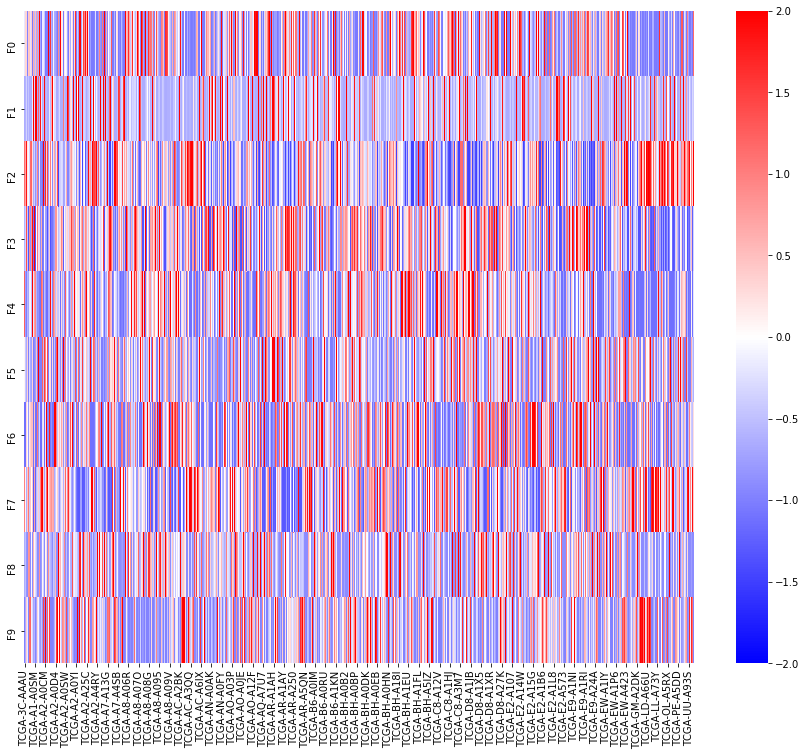

In [16]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(z_normalize_group(H_df),cmap="bwr",vmin=-2,vmax=2,center=0)
plt.show()

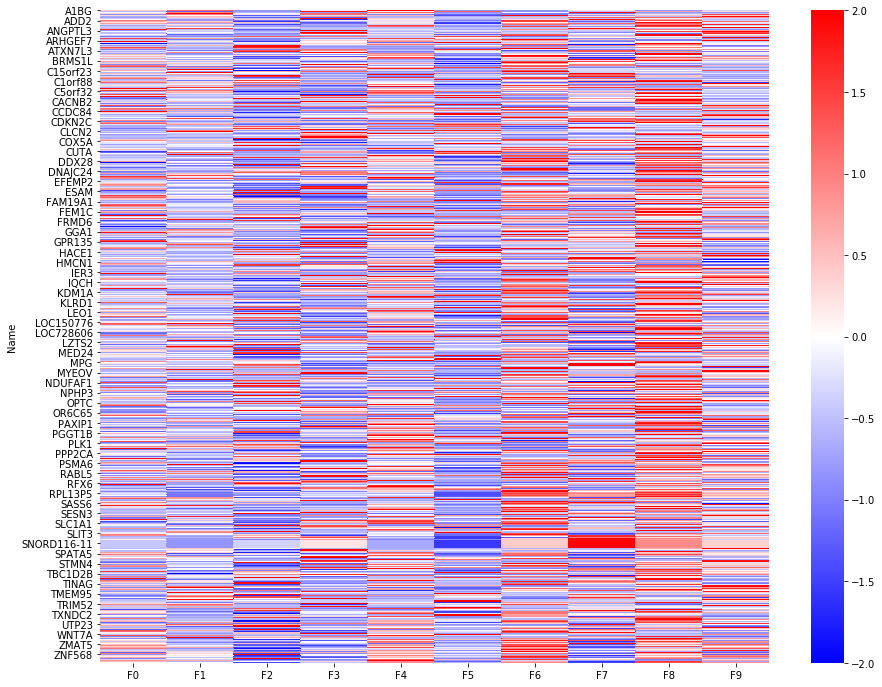

In [17]:
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(z_normalize_group(W_df),cmap="bwr",vmin=-2,vmax=2,center=0)
plt.show()

In [ ]:
'''gene_variance_series = expression_df.var(axis=1).sort_values(ascending=False)
gene_variance_series'''

In [ ]:
'''n_highest_variance_genes = 1000
genes_to_cluster_on = gene_variance_series.iloc[0:n_highest_variance_genes].index
genes_to_cluster_on'''

## 3. Make Clusters (the easy part)

In [18]:
W_row_linkage_obj = linkage(distance.pdist(W_df), method='average')
W_col_linkage_obj = linkage(distance.pdist(W_df.T), method='average')

H_row_linkage_obj = linkage(distance.pdist(H_df), method='average')
H_col_linkage_obj = linkage(distance.pdist(H_df.T), method='average')

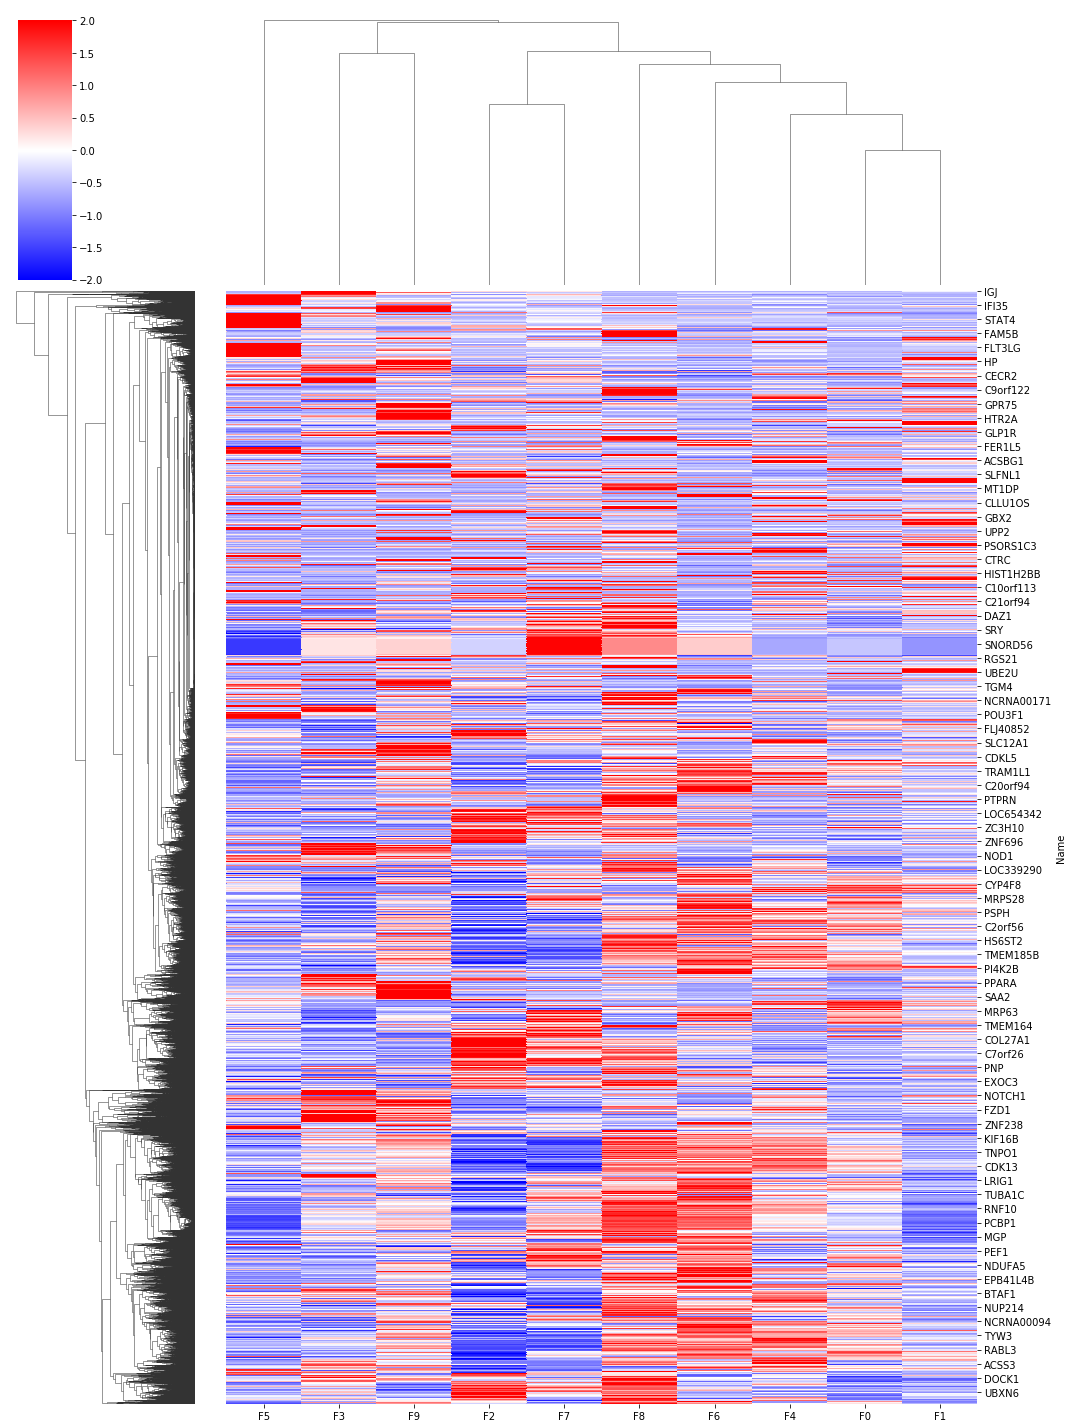

In [19]:
sns.clustermap(W_df,
               row_linkage=W_row_linkage_obj,
               col_linkage = W_col_linkage_obj,
               figsize=(15,20),
               #square=True,
               z_score=0,
               center=0,
               vmin=-2,
               vmax=2,
               cmap="bwr"
              )

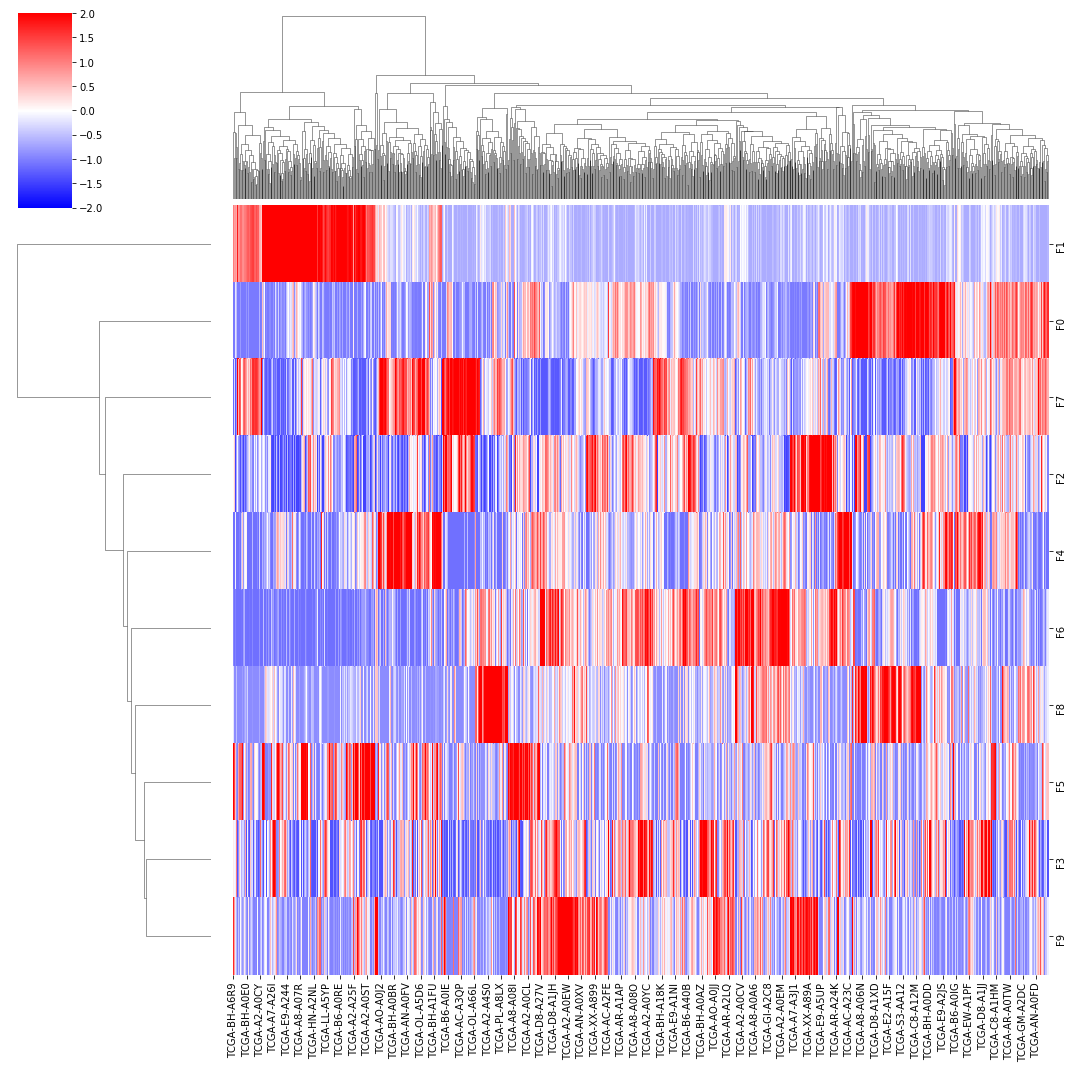

In [20]:
sns.clustermap(H_df,
               row_linkage=H_row_linkage_obj,
               col_linkage = H_col_linkage_obj,
               figsize=(15,15),
               #square=True,
               z_score=0,
               center=0,
               vmin=-2,
               vmax=2,
               cmap="bwr"
              )

In [21]:
colormap_hex = []
colormap_obj = cm.get_cmap('Paired')
for i in range(0,colormap_obj.N):
    colormap_hex.append(colors.rgb2hex(colormap_obj(i)))
colormap_hex

['#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928']

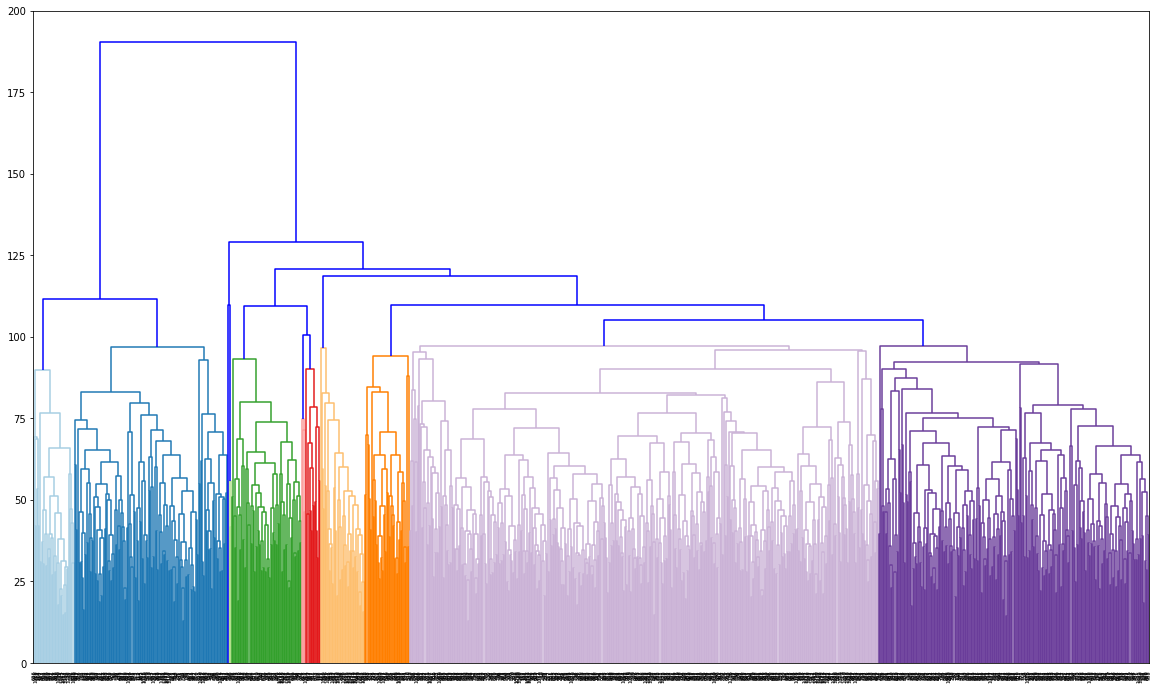

In [22]:
height_threshold = 100
plt.figure(figsize=(20, 12))
set_link_color_palette(colormap_hex)


#f, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(15,12), constrained_layout=True)
dendrogram_dict = dendrogram(H_col_linkage_obj,
                             orientation='top',
                             #labels=cluster_assignments_series.index,
                             distance_sort='descending',
                             color_threshold = height_threshold,
                             #link_color_func={i:color_palette_lst[i] for i in range(0,len(color_palette_lst))},
                             show_leaf_counts= False,
                             #ax=ax1
                            )
#ax2.imshow([cluster_assignments_series.iloc[dendrogram_dict["leaves"]].values]*100, cmap='Set2', interpolation='nearest')
plt.show()

In [153]:
pd.DataFrame({"color":dendrogram_dict['color_list'],"cluster":cluter_assignments_arr})

ValueError: arrays must all be same length

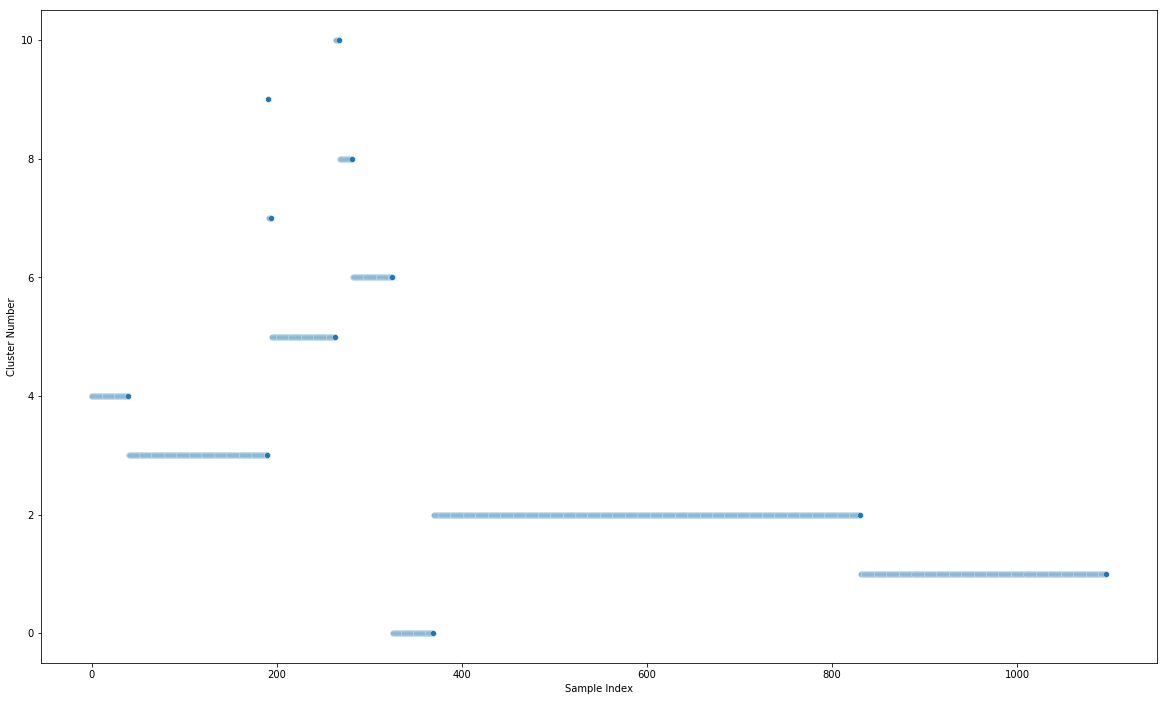

In [23]:
cluter_assignments_arr = cut_tree(H_col_linkage_obj,height=height_threshold).flatten()[dendrogram_dict["leaves"]]
plt.figure(figsize=(20, 12))
sns.scatterplot(x=range(0,len(cluter_assignments_arr)),y=cluter_assignments_arr)
plt.xlabel("Sample Index")
plt.ylabel("Cluster Number")
plt.show()

In [24]:
cluster_assignments_dict = {"sample":pd.Series(H_df.columns).iloc[dendrogram_dict["leaves"]].values,
                            "cluster":cluter_assignments_arr}
cluster_assignments_series = pd.DataFrame(cluster_assignments_dict).set_index("sample")["cluster"]
cluster_assignments_series = cluster_assignments_series
cluster_assignments_series.head()

sample
TCGA-BH-A6R9    4
TCGA-EW-A1P7    4
TCGA-S3-AA15    4
TCGA-E2-A1AZ    4
TCGA-A2-A4RX    4
Name: cluster, dtype: int32

In [25]:
cluster_assignments_series.value_counts()

2     461
1     266
3     151
5      69
6      44
0      44
4      40
8      14
10      4
7       3
9       1
Name: cluster, dtype: int64

## 2. Annotate Clusters

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

## 3. Survival Analysis

In [139]:
def KM_plot(cluster_assignments_series,
            vital_status_df,
            colormap_lst = None,
            title_txt = "KM Plot",
            vital_status_alive_txt = "Alive",
            vital_status_column = "vital_status",
            vital_status_time_column = 'event_time',
            fig_size = (20,15),):
    ax = None
    sample_group_medians_dict = {"sample_group":[],"median_survival":[]}
    sample_group_kmf_event_data_dict = dict()
    colormap_to_use = None
    
    for sample_group_name in np.sort(cluster_assignments_series.unique()): #sample_group_dict:
        samples_in_group_lst = cluster_assignments_series.loc[cluster_assignments_series==sample_group_name].index
        sample_group_count = len(samples_in_group_lst)
        time_data = vital_status_df.loc[samples_in_group_lst][vital_status_time_column].values
        event_data = vital_status_df.loc[samples_in_group_lst][vital_status_column].values
        event_data = np.where(event_data == vital_status_alive_txt, 0, 1)
        sample_group_kmf_event_data_dict[sample_group_name] = {"time_data":time_data,"event_data":event_data}
        
        kmf = KaplanMeierFitter()
        kmf.fit(time_data, event_data, label="{} (n={})".format(sample_group_name,sample_group_count))
        sample_group_medians_dict["sample_group"].append(sample_group_name)
        sample_group_medians_dict["median_survival"].append(kmf.median_survival_time_)
        color_to_use = None
        if colormap_lst is not None:
            color_to_use = colormap_lst[sample_group_name]
        if ax==None:
            ax = kmf.plot(show_censors=True, ci_show=False,figsize=fig_size,title=title_txt,color=color_to_use)
        else:
            ax = kmf.plot(show_censors=True, ci_show=False, ax=ax,color=color_to_use)

    sample_group_medians_df = pd.DataFrame(sample_group_medians_dict).set_index("sample_group")
    logrank_test_df_dict = {"cluster_A":[],
                              "cluster_A_median_survival":[],
                              "cluster_B":[],
                              "cluster_B_median_survival":[],
                              "p-value":[]} 
    for cluster_pair in itertools.combinations(sample_group_medians_df.index,2):
        logrank_test_df_dict["cluster_A"].append(cluster_pair[0])
        logrank_test_df_dict["cluster_A_median_survival"].append(sample_group_medians_df.loc[cluster_pair[0]]["median_survival"])
        logrank_test_df_dict["cluster_B"].append(cluster_pair[1])
        logrank_test_df_dict["cluster_B_median_survival"].append(sample_group_medians_df.loc[cluster_pair[1]]["median_survival"])
        logrank_test_result = logrank_test(sample_group_kmf_event_data_dict[cluster_pair[0]]["time_data"],
                                   sample_group_kmf_event_data_dict[cluster_pair[1]]["time_data"], 
                                   event_observed_A=sample_group_kmf_event_data_dict[cluster_pair[0]]["event_data"], 
                                   event_observed_B=sample_group_kmf_event_data_dict[cluster_pair[1]]["event_data"])
        logrank_test_df_dict["p-value"].append(logrank_test_result.p_value)
        ax.set_ylim(0,1.05)
        ax.set_xlim(0,)
    return ax, pd.DataFrame(logrank_test_df_dict).sort_values(by="p-value",ascending=True), sample_group_medians_df


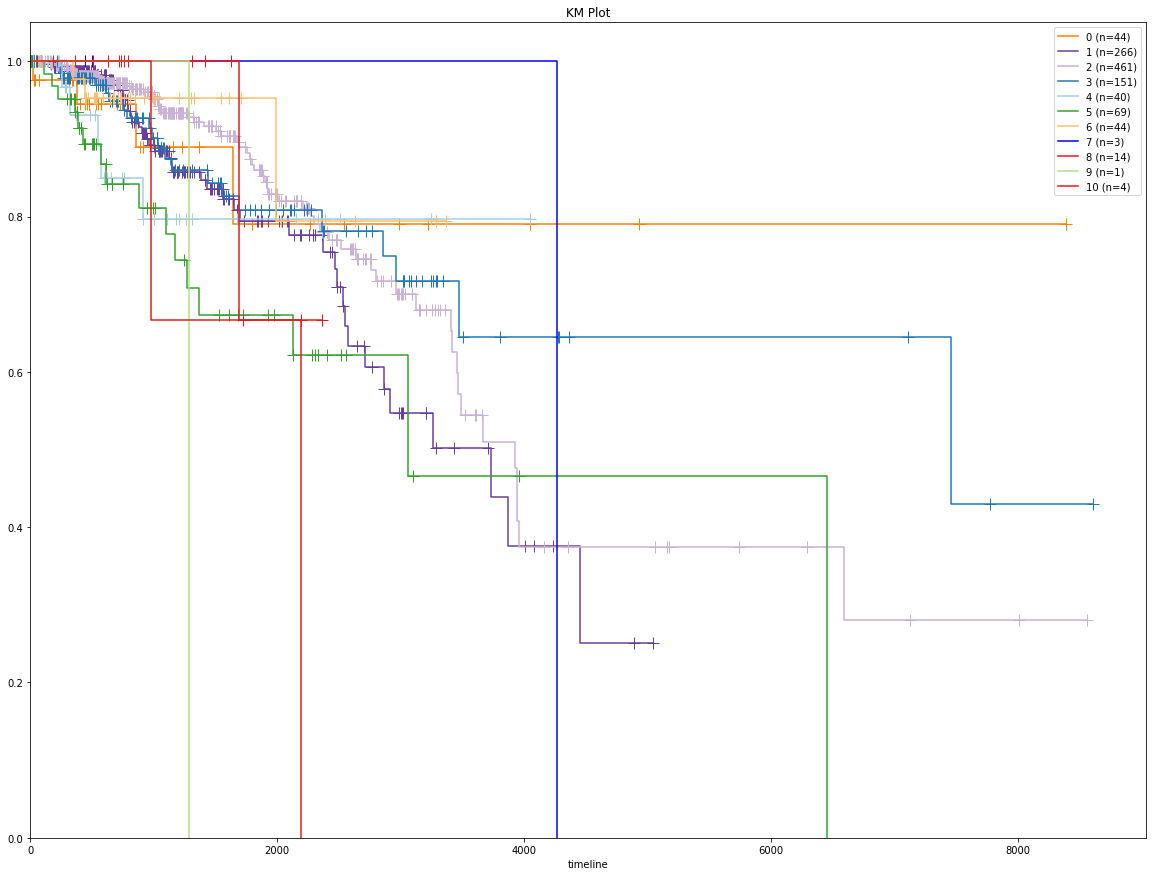

In [170]:
colormap_cluster_index_arr = np.array(dendrogram_dict['color_list'])[np.unique(cluter_assignments_arr, return_index=True)[1]]
KM_plot_ax, KM_stats_df, KM_medians_df = KM_plot(cluster_assignments_series,vital_status_df,colormap_lst=colormap_cluster_index_arr)


In [173]:
KM_medians_df

,median_survival
sample_group,
0,inf
1,3736.0
2,3926.0
3,7455.0
4,inf
5,3063.0
6,inf
7,4267.0
8,inf


In [171]:
KM_stats_df

,cluster_A,cluster_A_median_survival,cluster_B,cluster_B_median_survival,p-value
25,2,3926.0,9,1286.0,0.001171
21,2,3926.0,5,3063.0,0.001677
26,2,3926.0,10,2192.0,0.008067
28,3,7455.0,5,3063.0,0.009277
47,6,inf,9,1286.0,0.012675
52,8,inf,9,1286.0,0.014306
17,1,3736.0,9,1286.0,0.037466
32,3,7455.0,9,1286.0,0.039633
40,5,3063.0,6,inf,0.042704
33,3,7455.0,10,2192.0,0.052043
